In [44]:
!git clone https://github.com/stedy/Machine-Learning-with-R-datasets.git

fatal: destination path 'Machine-Learning-with-R-datasets' already exists and is not an empty directory.


In [45]:
import os

import pandas as pd

df = pd.read_csv(os.path.join("Machine-Learning-with-R-datasets", "insurance.csv"))
df

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830
1334,18,female,31.920,0,no,northeast,2205.98080
1335,18,female,36.850,0,no,southeast,1629.83350
1336,21,female,25.800,0,no,southwest,2007.94500


In [46]:
target = "charges"
features = ["age", "sex", "bmi", "children", "smoker", "region"]
X = df[features]
y = df[target]

In [47]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

categorical_features = ["sex", "smoker", "region"]
numerical_features = ["age", "bmi", "children"]
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(drop="first"), categorical_features),
        ("num", "passthrough", numerical_features),
    ]
)

In [48]:
from sklearn.model_selection import train_test_split

X_train, X_validtest, y_train, y_validtest = train_test_split(X, y, test_size=0.5, random_state=1)
X_valid, X_test, y_valid, y_test = train_test_split(X_validtest, y_validtest, test_size=0.5, random_state=2)

In [49]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.pipeline import make_pipeline


model = GradientBoostingRegressor(random_state=42)
pipeline = make_pipeline(preprocessor, model)
pipeline.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(drop='first'),
                                                  ['sex', 'smoker', 'region']),
                                                 ('num', 'passthrough',
                                                  ['age', 'bmi',
                                                   'children'])])),
                ('gradientboostingregressor',
                 GradientBoostingRegressor(random_state=42))])

In [50]:
features_transformed = [s.split("__")[-1] for s in preprocessor.get_feature_names_out()]
X_train_transformed = preprocessor.transform(X_train)
X_train_transformed = pd.DataFrame(X_train_transformed, columns=features_transformed)
X_valid_transformed = preprocessor.transform(X_valid)
X_valid_transformed = pd.DataFrame(X_valid_transformed, columns=features_transformed)

In [51]:
idx = 5 #Crucial line, we are looking at a specific instance in the dataset and therefore we are using a local method
x = X_valid.iloc[[idx]]

y_pred = pipeline.predict(x)[0]
y_true = y_valid.iloc[idx]

print(df.loc[x.index])
print(f"{y_true=:.3f}")
print(f"{y_pred=:.3f}")

     age     sex   bmi  children smoker     region   charges
126   19  female  28.3         0    yes  southwest  17081.08
y_true=17081.080
y_pred=16872.796


In [52]:
import numpy as np

plot_dfs = []
x_transformed = X_valid_transformed.iloc[[idx]]
for feature in features_transformed:
    min_ = X_train_transformed[feature].min()
    max_ = X_train_transformed[feature].max()
    values = np.linspace(min_, max_, 201)
    input_df = pd.concat([x_transformed] * len(values), ignore_index=True)
    input_df[feature] = values
    predictions = model.predict(input_df.values)
    plot_df = pd.DataFrame({
        "value": values,
        "target": predictions,
    })
    plot_df["feature"] = feature
    plot_df["type"] = "pred"
    plot_dfs.append(plot_df)
    original_df = pd.DataFrame({
        "value": x_transformed[feature].values,
        "target": [y_true],
    })
    original_df["feature"] = feature
    original_df["type"] = "true"
    plot_dfs.append(original_df)


In [53]:
import plotly.express as px

fig = px.line(pd.concat(plot_dfs, ignore_index=True), x="value", y="target", facet_col="feature", color="type", markers=True)
fig.update_xaxes(matches=None)
fig

#Smoker feature (Cost would have been considerably lower if the person was not a smoker)
#Age Feature (Quite a non-linear behavior)
#BMI Feature (Also quite a non-linear behavior)
#Children Feature (Almost linear behavior) => If the person would have had childern, the cost would have been even lower^(weirdly)

In [54]:
import matplotlib.pyplot as plt
from sklearn.inspection import PartialDependenceDisplay

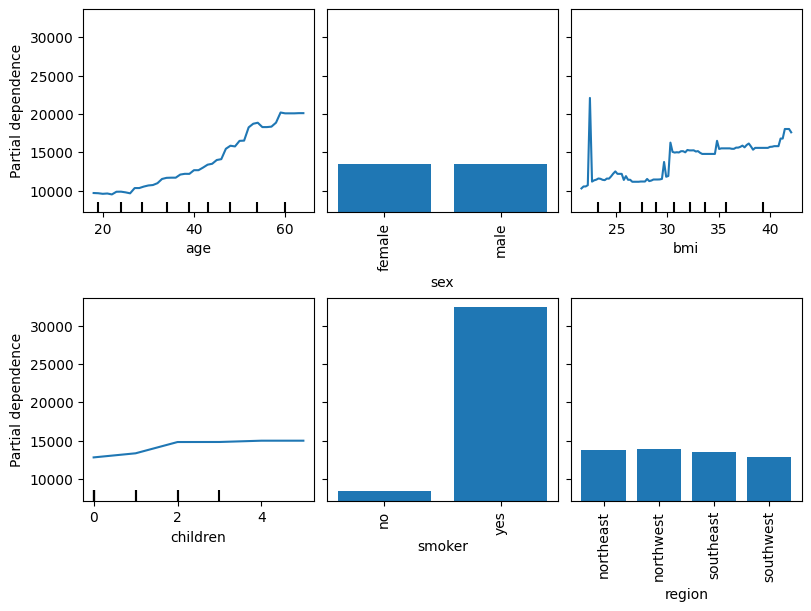

In [55]:
_, ax = plt.subplots(ncols=3, nrows=2, figsize=(8, 6), constrained_layout=True)
display = PartialDependenceDisplay.from_estimator(
    estimator=pipeline,
    X=X_valid,
    features=X_valid.columns,
    categorical_features=categorical_features,
    ax=ax,
    kind="average",
    # centered=True,
)

In [56]:
model = model.fit(X_train_transformed, y_train)

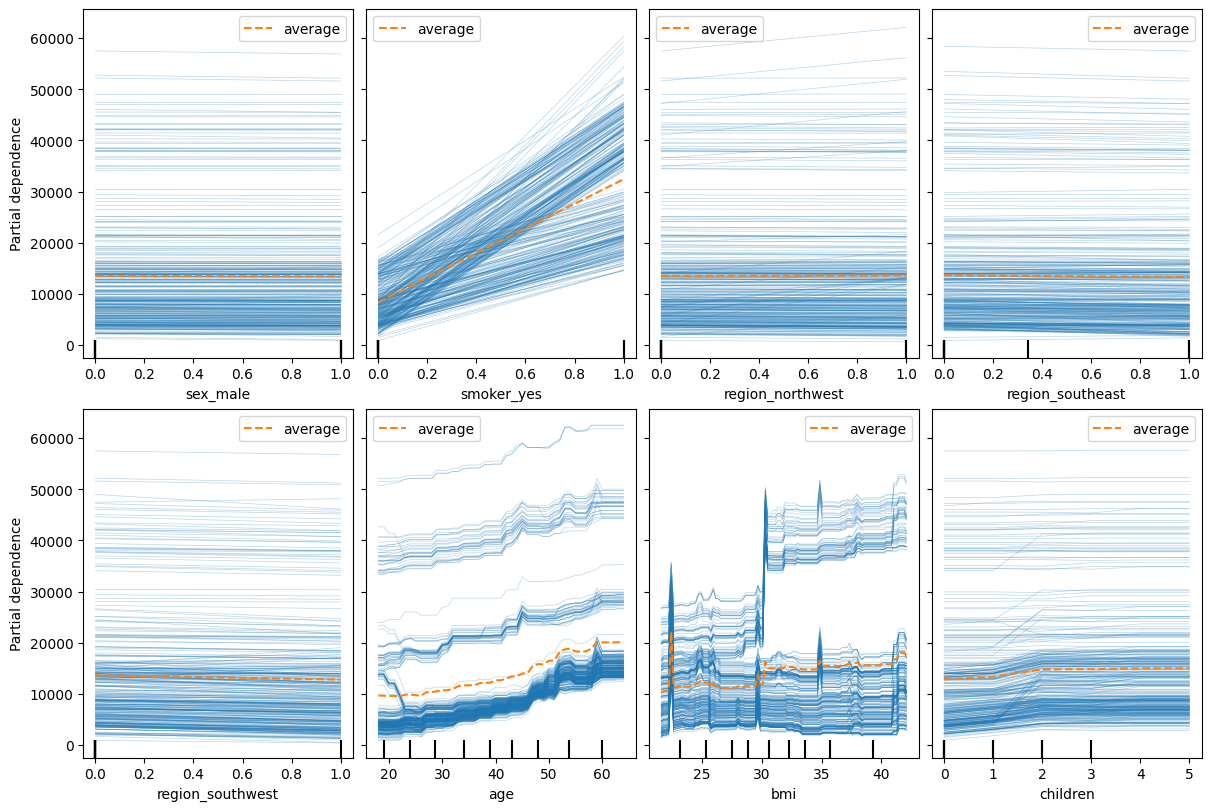

In [57]:
_, ax = plt.subplots(ncols=4, nrows=2, figsize=(12, 8), constrained_layout=True)
display = PartialDependenceDisplay.from_estimator(
    estimator=model,
    X=X_valid_transformed,
    features=features_transformed,
    ax=ax,
    kind="both",
    # centered=True,
    pd_line_kw={"color": "tab:orange", "linestyle": "--"},
)

In [58]:
!pip install dalex

  Using cached plotly-5.24.1-py3-none-any.whl.metadata (7.3 kB)
Using cached plotly-5.24.1-py3-none-any.whl (19.1 MB)
  Attempting uninstall: plotly
    Found existing installation: plotly 6.3.1
    Uninstalling plotly-6.3.1:
      Successfully uninstalled plotly-6.3.1


In [59]:
from dalex import Explainer
from dalex.predict_explanations import CeterisParibus

explainer = Explainer(model=model, data=X_train_transformed, y=y_train)
cp = CeterisParibus()
cp.fit(explainer=explainer, new_observation=x_transformed, y=np.array([y_true]))
cp.plot()

Preparation of a new explainer is initiated

  -> data              : 669 rows 8 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 669 values
  -> model_class       : sklearn.ensemble._gb.GradientBoostingRegressor (default)
  -> label             : Not specified, model's class short name will be used. (default)
  -> predict function  : <function yhat_default at 0x7ff27ce78c20> will be used (default)
  -> predict function  : Accepts pandas.DataFrame and numpy.ndarray.
  -> predicted values  : min = 1.1e+03, mean = 1.35e+04, max = 6.21e+04
  -> model type        : regression will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -5.51e+03, mean = 1.85e-13, max = 1.92e+04
  -> model_info        : package sklearn

A new explainer has been created!


Calculating ceteris paribus: 100%|██████████| 8/8 [00:00<00:00, 878.34it/s]
/home/nevin/miniconda3/envs/time/lib/python3.11/site-packages/dalex/predict_explanations/_ceteris_paribus/object.py:221: UserWarning:

'show_observations' parameter changed to False,because the 'variable_splits_with_obs' attribute is FalseSee `variable_splits_with_obs` parameter in `predict_profile`.

